In [1]:
import numpy as np
import os, sys
import keras
import keras.backend as K
from PIL import Image
import random
import glob
import pickle
from keras.preprocessing.image import load_img, img_to_array
from bcolz_array_iterator import BcolzArrayIterator
from tqdm import tqdm
import bcolz
import threading
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from time import sleep
%matplotlib inline

Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close() #new line lets you reset GPU memory without closing notebook
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [3]:
DATA_PATH='/home/bfortuner/workplace/data/imagenet_sample/'
RESIZED_PATH='/home/bfortuner/workplace/data/image_resizing/'

In [4]:
# Save image filenames
fnames = list(glob.iglob(DATA_PATH+'*/*.JPEG'))
pickle.dump(fnames, open(DATA_PATH+'fnamesfullpath.p', 'wb'))
fnames = pickle.load(open(DATA_PATH+'fnamesfullpath.p', 'rb'))

#Randomly Order Filenames (important for later steps w bcolz)
#fnames = np.random.permutation(fnames)
#pickle.dump(fnames, open(DATA_PATH+'fnamesfullpath_random.p', 'wb'))
#fnames = pickle.load(open(DATA_PATH+'fnamesfullpath_random.p', 'rb'))

NEW_SIZE = 72 #h x w to resize to
len(fnames)

19439

/home/bfortuner/workplace/data/imagenet_sample/n02018795/n02018795_4032.JPEG


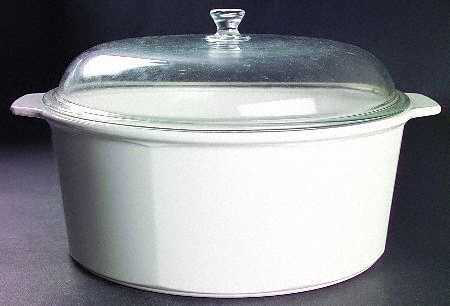

In [5]:
### Explore Images

def get_paths_to_files(dir_path):
    filepaths = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
    return filepaths

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)
    return filepaths[random.randrange(len(filepaths))]

print (get_random_image_path(DATA_PATH))
load_img(get_random_image_path(DATA_PATH))

### Technique 1 - Pillow SIMD
* https://pillow.readthedocs.io/en/4.0.x
* https://github.com/uploadcare/pillow-simd
* https://python-pillow.org/pillow-perf/
* Pillow Original - 15.2 seconds per 4000 images
* Pillow-SIMD - 12.7 secs per 4000 images
How much faster is SIMD than Original?
* http://math.stackexchange.com/questions/1227389/what-is-the-difference-between-faster-by-factor-and-faster-by-percent
* (15.2 - 12.7) / 12.7 = ~20% faster
* 20% speedup

In [6]:
# Force uninstall old version, then install pillow-simd\n#$ pip uninstall pillow
#$ CC=\"cc -mavx2\" pip install -U --force-reinstall pillow-simd
#12 seconds per 4000 images
import PIL
print (PIL.PILLOW_VERSION)

4.0.0.post0


In [7]:
def resize_open_img(img):
    oldsize = img.size
    img.resize((224,224))
    img.resize(oldsize)
    return img

def resize_open_imgs(imgs):
    return [resize_open_img(img) for img in imgs]

In [8]:
imgs = [Image.open(f) for f in fnames[:800]]
%timeit -n 1 res = [resize_open_imgs(imgs) for i in range(50)]
for img in imgs:
    img.close()

1 loop, best of 3: 5.84 s per loop


I'm not getting the speedups with this example, but it's probably a bad example. I do get huge speedups when I run the benchmark code here. https://github.com/python-pillow/pillow-perf#automatic-test

In [12]:
'''
Scale 2560×1600 RGB image
    to 26x16 bil        0.00407 s  1006.73 Mpx/s
    to 26x16 bic        0.00311 s  1315.36 Mpx/s
    to 26x16 lzs        0.00528 s   775.33 Mpx/s
    to 320x200 bil      0.00226 s  1811.27 Mpx/s
    to 320x200 bic      0.00388 s  1054.76 Mpx/s
    to 320x200 lzs      0.00616 s   665.19 Mpx/s
    to 2048x1280 bil    0.01036 s   395.31 Mpx/s
    to 2048x1280 bic    0.01402 s   292.12 Mpx/s
    to 2048x1280 lzs    0.01747 s   234.41 Mpx/s
    to 5478x3424 bil    0.04935 s    83.00 Mpx/s
    to 5478x3424 bic    0.06068 s    67.50 Mpx/s
    to 5478x3424 lzs    0.07678 s    53.35 Mpx/s


Scale 2560×1600 RGB image
    to 26x16 bil        0.00711 s   576.31 Mpx/s
    to 26x16 bic        0.01341 s   305.54 Mpx/s
    to 26x16 lzs        0.02038 s   200.97 Mpx/s
    to 320x200 bil      0.01093 s   374.70 Mpx/s
    to 320x200 bic      0.01958 s   209.21 Mpx/s
    to 320x200 lzs      0.02783 s   147.18 Mpx/s
    to 2048x1280 bil    0.03533 s   115.94 Mpx/s
    to 2048x1280 bic    0.04849 s    84.48 Mpx/s
    to 2048x1280 lzs    0.06681 s    61.31 Mpx/s
    to 5478x3424 bil    0.16516 s    24.80 Mpx/s
    to 5478x3424 bic    0.21066 s    19.44 Mpx/s
    to 5478x3424 lzs    0.26933 s    15.21 Mpx/s
'''
None

### Technique 2 - Bcolz Array

In [6]:
#New python 3 string substitution
bcolz_file_path = f'{DATA_PATH}trn_resized_{NEW_SIZE}.bc'
bcolz_file_path

'/home/bfortuner/workplace/data/imagenet_sample/trn_resized_72.bc'

In [7]:
arr = bcolz.carray(np.empty((0, NEW_SIZE, NEW_SIZE, 3), 'float32'), 
                   chunklen=16, mode='w', rootdir=bcolz_file_path)

In [8]:
#Pre-allocate memory
tl = threading.local()
tl.place = np.zeros((NEW_SIZE,NEW_SIZE,3), 'uint8')

In [9]:
#https://github.com/noamraph/tqdm
def resize_images_bcolz(bc_arr, fnames, new_s):
    for i in tqdm(range(len(fnames))):
        f = fnames[i]        
        img = resize_img(f, new_s)
        elem = app_img(img, new_s)
        bc_arr.append(elem)
    return bc_arr

### Technique 3 - Parallel Processing

In [20]:
#Serial Version
%time resize_images_bcolz(arr,fnames[:4000],NEW_SIZE)
arr.flush()

  0%|          | 0/4000 [00:00<?, ?it/s]


NameError: name 'resize_img' is not defined

### Python Map

* https://docs.python.org/3/library/functions.html#map
* Return an iterator that applies function to every item of iterable, yielding the results.

In [10]:
#All 3 are equivalent 

#Normal loop
result = []
for c in "Andrew":
    result.append(ord(c))

# List comprehension
[ord(c) for c in "Brendan"]

#Map
map(ord, "Brendan")

In [11]:
#Convert Map iterator to list
iter_result = map(ord, "Brendan")
list_version = list(iter_result)
list_version

[66, 114, 101, 110, 100, 97, 110]

In [12]:
#Loop through iterator returned by Map
iter_result = map(ord, "Brendan")
for elem in iter_result:
    print(elem)

66
114
101
110
100
97
110


In [13]:
#once you "unpack" the values in the iterator you can't get them back
list(iter_result)

[]

In [14]:
#Multiple iterator parameters to map function (must be iterators)
#http://stackoverflow.com/questions/10834960/how-to-do-multiple-arguments-to-map-function-where-one-remains-the-same-in-pytho
def add_two(num, two):
    return num+two

res = map(add_two, [i for i in range(5)], [2 for i in range(5)])
list(res)

[2, 3, 4, 5, 6]

### Multithreading

In [18]:
#http://masnun.com/2016/03/29/python-a-quick-introduction-to-the-concurrent-futures-module.html
#Executor.map() example
def add_two(num, two):
    return num+two

def parallel(nums, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(add_two, nums, [2 for i in range(len(nums))])
    return list(res)

nums = [i for i in range(10000)]

In [16]:
%timeit parallel(nums,1)
%timeit parallel(nums,10)
%timeit parallel(nums,100)

1 loop, best of 3: 184 ms per loop
1 loop, best of 3: 371 ms per loop
1 loop, best of 3: 446 ms per loop


**Why is it getting slower the more threads we have?**<br>
1. GIL could be an explanation
2. Spinning up multiple threads takes time, and since this is such a simple operation it doesn't save time
3. Since we're using multiple threads in the same PROCESS, we don't benefit from the CPUs multiple cores, so more threads just means the OS is switching between the threads
4. We should expect to see improvements when IO operations are involved. Or not?

### IO Example

In [17]:
#IO example
def open_file(fpath):
    img = Image.open(fpath)
    img.close()
    img = Image.open(fpath)
    img.close()
    img = Image.open(fpath)
    img.close()
    img = Image.open(fpath)
    img.close()
    img = Image.open(fpath)
    img.close()
    img = Image.open(fpath)
    img.close()
    return fpath
    
def multithreading_io(fnames, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        fpaths = executor.map(open_file, fnames)
    return list(fpaths)

In [54]:
print(len(fnames))
test_fnames = fnames[:10000]
print(len(test_fnames))

19439
10000


In [55]:
%timeit multithreading_io(test_fnames,1)[:100]
%timeit multithreading_io(test_fnames,2)[:100]
%timeit multithreading_io(test_fnames,8)[:100]

1 loop, best of 3: 3.21 s per loop
1 loop, best of 3: 6.08 s per loop
1 loop, best of 3: 13.1 s per loop


**WTF? No speedup with multiple threads still???**<br>

CPython has the Global Interpreter Lock which prevents multiple threads from running Python code at the same time. On the other hand, this task is doing file I/O, and gzip uncompression in code which might release the GIL. Perhaps processes will work here?

The GIL is controversial because it prevents multithreaded CPython programs from taking full advantage of multiprocessor systems in certain situations. Note that potentially blocking or long-running operations, such as I/O, image processing, and NumPy number crunching, happen outside the GIL. Therefore it is only in multithreaded programs that spend a lot of time inside the GIL, interpreting CPython bytecode, that the GIL becomes a bottleneck.

But this is IO? Probably caching the image im memory so it's not blocked by SSD access?

### Multiprocessing

In [56]:
def multiprocessing_io(fnames, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        fpaths = executor.map(open_file, fnames)
    return list(fpaths)

In [57]:
print(len(fnames))
test_fnames = fnames[:10000]
print(len(test_fnames))

19439
10000


In [58]:
%timeit multiprocessing_io(test_fnames,1)[:100]
%timeit multiprocessing_io(test_fnames,2)[:100]
%timeit multiprocessing_io(test_fnames,8)[:100]

1 loop, best of 3: 3.89 s per loop
1 loop, best of 3: 2.28 s per loop
1 loop, best of 3: 2.21 s per loop


Ok so I'm seeing improvement when my function is longer and more IO intensive. The overhead from starting processes is too large for very small fast functions. So you need to do larger functions.

### API Calls

API calls - I'm seeing speedsups. This suggests the GIL isn't used for this type of function

In [59]:
from urllib.request import Request, urlopen, URLError

URL='http://placekitten.com/'
URLS=[URL for i in range(10)]

def call_api(url):
    request = Request(url)
    try:
        response = urlopen(request)
        kittens = response.read()
        return kittens[559:1000]
    except (URLError, e):
        print ('No kittez. Got an error code: %s' % e)
        
def multithreading_api(urls, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        resp = executor.map(call_api, urls)
    return list(resp)

def multiprocessing_api(urls, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        resp = executor.map(call_api, urls)
    return list(resp)

In [60]:
urls = [URL for i in range(50)]

Seeing speedups for multithreading

In [ ]:
%timeit multithreading_api(urls,1)[:100]
%timeit multithreading_api(urls,2)[:100]
%timeit multithreading_api(urls,8)[:100]

1 loop, best of 3: 4.34 s per loop
1 loop, best of 3: 2.21 s per loop


Seeing speedups for multiprocessing. Probably the overhead from the multiple processes slows things down since the function is so simple

In [ ]:
%timeit multiprocessing_api(urls,1)[:100]
%timeit multiprocessing_api(urls,2)[:100]
%timeit multiprocessing_api(urls,8)[:100]

### Generic Concurrent Functions

In [6]:
def multithreading(func, args, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args)
    return list(res)
        
def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args)
    return list(res)

### Numpy Functions

In [31]:
DIMS = 10000
NUM_OPERATIONS = 20
DIMS_ARR = [DIMS for i in range(NUM_OPERATIONS)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

def dot_product(i):
    return np.dot(a,b)

def addition(i):
    return a + b

Addition

In [28]:
#Serial
%timeit res = [addition(i) for i in range(NUM_OPERATIONS)]

1 loop, best of 3: 6.77 s per loop


In [29]:
%timeit res = multithreading(addition, [i for i in range(NUM_OPERATIONS)], 4)

1 loop, best of 3: 3.26 s per loop


In [30]:
%timeit res = multiprocessing(addition, [i for i in range(NUM_OPERATIONS)], 4)

1 loop, best of 3: 29.1 s per loop


In [14]:
#Serial
%timeit res = [dot_product() for i in range(NUM_OPERATIONS)]

1 loop, best of 3: 7.98 s per loop


**Multithreading**

In [83]:
%timeit res = multithreading(dot_product, DIMS_ARR, 1)

1 loop, best of 3: 5.8 s per loop


In [15]:
%timeit res = multithreading(dot_product, DIMS_ARR, 2)

1 loop, best of 3: 8.5 s per loop


In [85]:
%timeit res = multithreading(dot_product, DIMS_ARR, 5)

1 loop, best of 3: 6.13 s per loop


**Multiprocessing**

In [86]:
%timeit res = multiprocessing(dot_product, DIMS_ARR, 1)

1 loop, best of 3: 6.45 s per loop


In [16]:
%timeit res = multiprocessing(dot_product, DIMS_ARR, 2)

1 loop, best of 3: 9.2 s per loop


In [88]:
%timeit res = multiprocessing(dot_product, DIMS_ARR, 5)

1 loop, best of 3: 5.73 s per loop


Let's try bigger arrays. Fewer Operations.

In [21]:
DIMS = 5000
NUM_OPERATIONS = 10
DIMS_ARR = [DIMS for i in range(NUM_OPERATIONS)]

In [90]:
#Serial
%timeit res = [dot_product(DIMS) for i in range(N)]

1 loop, best of 3: 9.32 s per loop


In [91]:
#Multithreading
%timeit res = multithreading(dot_product, DIMS_ARR, 2)

1 loop, best of 3: 9.22 s per loop


In [94]:
#Multiprocessing
%timeit res = multiprocessing(dot_product, DIMS_ARR, 2)

1 loop, best of 3: 10 s per loop


### Image Resizing

100


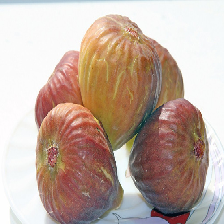

In [21]:

#This one takes IO so multithreading might be better?
def resize_img(fpath):
    img = Image.open(fpath)
    rimg = img.resize((224,224))
    img.close()
    return rimg

def resize_imgs(fpaths):
    return [resize_img(f) for f in fpaths]

test_fnames = fnames[:100]
img = resize_img(get_random_image_path(DATA_PATH))
imgs = resize_imgs(test_fnames)
print (len(imgs))
imgs[0]

In [50]:
test_fnames = fnames[:12000]
len(test_fnames)

12000

In [41]:
#Serial
%timeit res = [resize_img(f) for f in test_fnames]

1 loop, best of 3: 34.5 s per loop


Multithreading

In [42]:
#Multithreading
%timeit res = multithreading(resize_img, test_fnames, 2)

1 loop, best of 3: 17.5 s per loop


In [43]:
#Multithreading
%timeit res = multithreading(resize_img, test_fnames, 4)

1 loop, best of 3: 9.28 s per loop


In [46]:
#Multithreading
%timeit res = multithreading(resize_img, test_fnames, 8)

1 loop, best of 3: 7.81 s per loop


In [49]:
#Multithreading
#At some point we lose the benefits due to overhead of managing so many threads..
%timeit res = multithreading(resize_img, test_fnames, 16)

1 loop, best of 3: 8.12 s per loop


Multiprocessing<br>

Doesn't seem to work as well as multithreading... Combining the results together must be time-consuming or the overhead of managing the larger processes...

In [44]:
#Multiprocessing
%timeit res = multiprocessing(resize_img, test_fnames, 2)

1 loop, best of 3: 19.2 s per loop


In [47]:
#Multiprocessing
%timeit res = multiprocessing(resize_img, test_fnames, 4)

1 loop, best of 3: 11.6 s per loop


In [48]:
#Multiprocessing
%timeit res = multiprocessing(resize_img, test_fnames, 8)

1 loop, best of 3: 10.4 s per loop


In [50]:
#Multiprocessing
%timeit res = multiprocessing(resize_img, test_fnames, 16)

1 loop, best of 3: 13.3 s per loop


In [23]:
def get_fname_groups(step, fnames):
    fname_groups = []
    for i in range(0,len(fnames),step):
        fname_groups.append(fnames[i:i+step])
    return fname_groups

### What about passing in groups of filenames?

No Improvement

In [34]:
step = 3000
test_fnames = fnames[:12000]
fname_groups = get_fname_groups(step, test_fnames)
print (len(fname_groups))
print (len(fname_groups[0]))

4
3000


In [35]:
#Serial
%timeit res = [resize_imgs(group) for group in fname_groups]

1 loop, best of 3: 34.5 s per loop


In [36]:
#Multithreading
%timeit res = multithreading(resize_imgs, fname_groups, 2)

1 loop, best of 3: 18.7 s per loop


In [37]:
#Multithreading
%timeit res = multithreading(resize_imgs, fname_groups, 4)

1 loop, best of 3: 9.41 s per loop


In [38]:
#Multiprocessing
%timeit res = multiprocessing(resize_imgs, fname_groups, 2)

1 loop, best of 3: 19.7 s per loop


In [39]:
#Multiprocessing
%timeit res = multiprocessing(resize_imgs, fname_groups, 4)

1 loop, best of 3: 12 s per loop


### Image Resizing w/o IO

In [7]:
def resize_open_img(img):
    img = img.resize((224,224))
    return img

def resize_open_imgs(imgs):
    return [resize_open_img(img) for img in imgs]

In [8]:
imgs = [Image.open(f) for f in fnames[:500]]
imgs[0]
for i in imgs:
    i.close()

**Serial**<br>
Running only a single task, as opposed to multitasking.

In [14]:
#Serial
imgs = [Image.open(f) for f in fnames[:500]]
%timeit res = resize_open_imgs(imgs)

The slowest run took 32.64 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 39.7 ms per loop


In [13]:
#serial
def mthread_serial(fnames, step):
    for f in range(0,len(fnames),step):
        imgs = [Image.open(f) for f in fnames[f:f+step]]
        rimgs = resize_open_imgs(imgs)
        for r in rimgs:
            r.close()
            
%timeit mthread_serial(fnames[:10000], 500)

1 loop, best of 3: 29.3 s per loop


In [14]:
def close_imgs(imgs):
    for img in imgs:
        img.close()    

In [15]:
#Multithreading
def mthread_groups(fnames, step, workers):
    for f in range(0,len(fnames),step):
        imgs = [Image.open(f) for f in fnames[f:f+step]]
        rimgs = multithreading(resize_open_img, imgs, workers)
        for r in rimgs:
            r.close()
        
%timeit mthread_groups(fnames[:10000], 500, 4)

1 loop, best of 3: 9.61 s per loop


In [16]:
#Multithreading
def mprocess_groups(fnames, step, workers):
    for f in range(0,len(fnames),step):
        imgs = [Image.open(f) for f in fnames[f:f+step]]
        rimgs = multiprocessing(resize_open_img, imgs, workers)
        for r in rimgs:
            r.close()
        
%timeit mprocess_groups(fnames[:10000], 500, 4)

1 loop, best of 3: 39.9 s per loop


### CPU Intensive Task

In [17]:
def silly_loop(n):
    count = 0
    for i in range(n):
        count += i
    return count

In [21]:
nums = [10000000 for i in range(10)]

In [22]:
#Serial
%timeit res = [silly_loop(n) for n in nums]

1 loop, best of 3: 3.99 s per loop


No benefit whatsoever for multithreading on CPU-intensive tasks.

This makes perfect sense! Because of GIL!

Python has an added issue: There's a Global Interpreter Lock that prevents two threads in the same process from running Python code at the same time. This means that if you have 8 cores, and change your code to use 8 threads, it won't be able to use 800% CPU and run 8x faster; it'll use the same 100% CPU and run at the same speed. (In reality, it'll run a little slower, because there's extra overhead from threading, even if you don't have any shared data, but ignore that for now.)

In [27]:
#Multithreading
%timeit res = multithreading(silly_loop, nums, 2)

1 loop, best of 3: 5.25 s per loop


In [28]:
#Multithreading
%timeit res = multithreading(silly_loop, nums, 4)

1 loop, best of 3: 5.48 s per loop


In [29]:
#Multithreading
%timeit res = multithreading(silly_loop, nums, 8)

1 loop, best of 3: 5.79 s per loop


Multiprocessing is awesome for CPU-intensive tasks. It is taking advantage of the multiple CPUs. But eventually the number of processes starts to erode performance because the overhead of maintaining the multiple processes and combining their results (with pickling) outweighs the benefits of parallization.

In [30]:
#Multiprocessing
%timeit res = multiprocessing(silly_loop, nums, 2)

1 loop, best of 3: 2.05 s per loop


In [31]:
#Multiprocessing
%timeit res = multiprocessing(silly_loop, nums, 4)

1 loop, best of 3: 1.25 s per loop


In [32]:
#Multiprocessing
%timeit res = multiprocessing(silly_loop, nums, 8)

1 loop, best of 3: 1.36 s per loop
